[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`. 

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import torch

input = torch.randn(64, 10, 20, 20)
# aumentamos la dimensión x2
conv_trans = torch.nn.ConvTranspose2d(
    in_channels=10, 
    out_channels=10, 
    kernel_size=2, 
    stride=2)
output = conv_trans(input)
output.shape

torch.Size([64, 10, 40, 40])

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=12734f7a2bc9ecf002e065edaeeabb8bb9ad891254ed296cb9f54c36a8ac1495
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
wget.download(url)

'MRIs.zip'

In [ ]:
import zipfile
with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca. Determinar la cantidad de ambas así como su evolución en el tiempo para un mismo paciente es clave para la detección temprana y tratamiento de enfermedades como el alzheimer. 

In [1]:
import os 
from pathlib import Path

path = Path('/content/drive/MyDrive/plastoformo')
imgs = [path/'train_mask'/i for i in os.listdir(path/'train_mask') if i.endswith('.jpg')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'train_mask')]
masks = [path/'train_mask'/(Path(img).stem + '_mask.png') for img in imgs]

len(imgs), len(masks)

(1000, 1000)

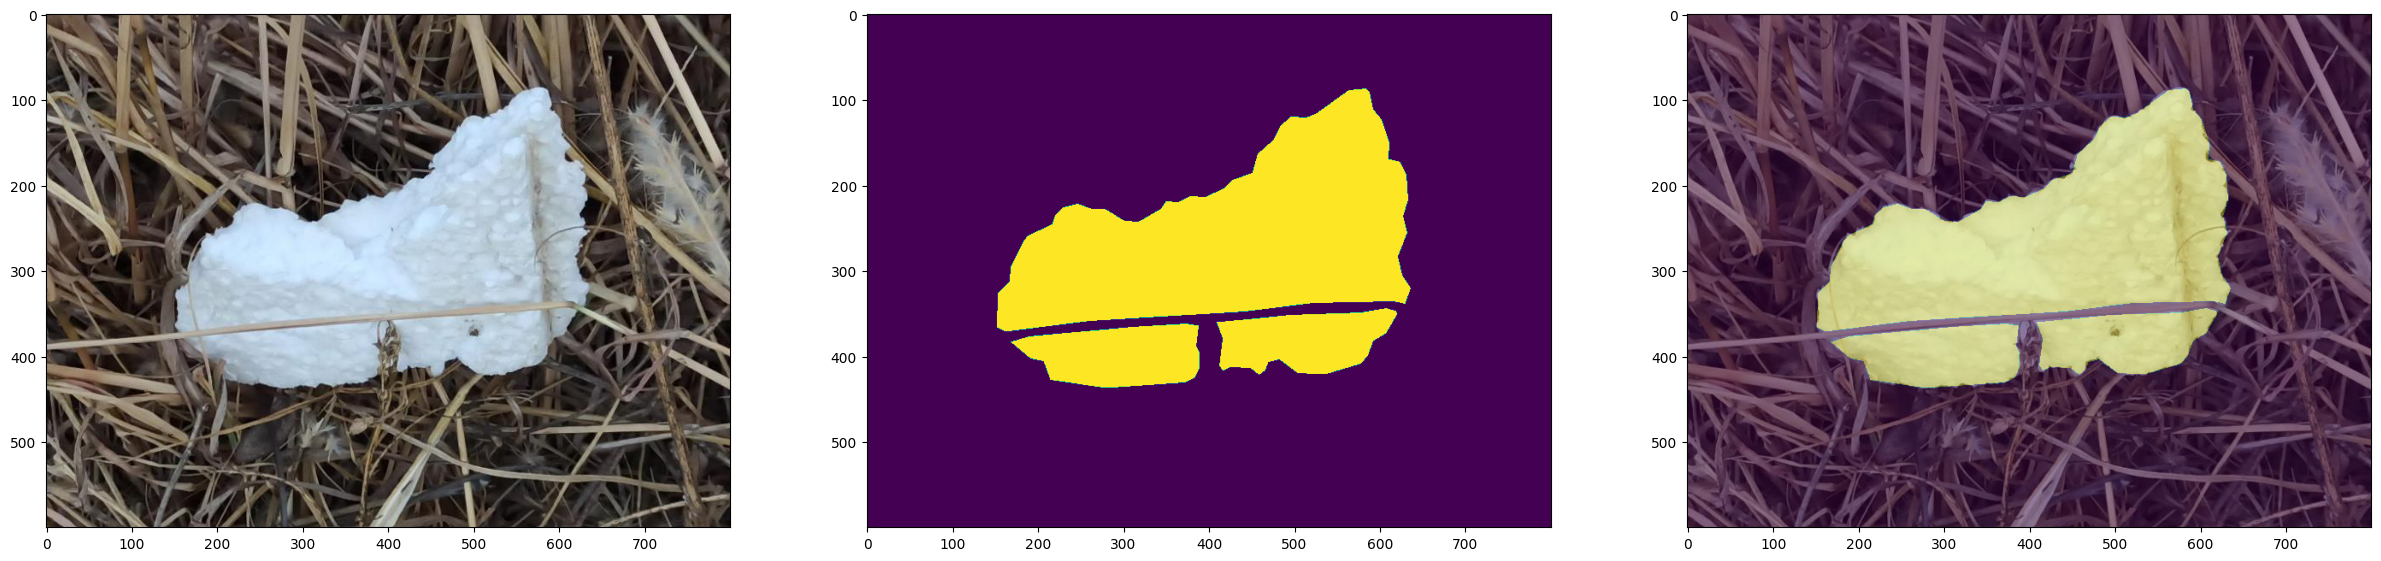

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = Image.open(imgs[1])



mask = np.array(Image.open(masks[1]))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [3]:
width, height = img.size
img_array = np.array(img)
dtype = img_array.dtype
max_value = img_array.max()
min_value = img_array.min()

print("Dimensiones de la imagen: ", width, "x", height)
print("Tipo de datos: ", dtype)
print("Valor máximo: ", max_value)
print("Valor mínimo: ", min_value)


Dimensiones de la imagen:  800 x 600
Tipo de datos:  uint8
Valor máximo:  255
Valor mínimo:  0


En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [4]:
mask_array = np.array(mask)
mask_dtype = mask_array.dtype
mask_max_value = mask_array.max()
mask_min_value = mask_array.min()

print("Dimensiones de la máscara: ", mask_array.shape)
print("Tipo de datos de la máscara: ", mask_dtype)
print("Valor máximo de la máscara: ", mask_max_value)
print("Valor mínimo de la máscara: ", mask_min_value)


Dimensiones de la máscara:  (600, 800)
Tipo de datos de la máscara:  uint8
Valor máximo de la máscara:  1
Valor mínimo de la máscara:  0


A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [5]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((600, 800, 3), dtype('float32'), 1.0, 0.0)

## UNet

Vamos ahora a implementar nuestra red neuronal similar a `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [8]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [9]:
model = UNet()
output = model(torch.randn((10,3,800,600)))
output.shape

torch.Size([10, 3, 800, 600])

## Fit de 1 muestra

Para comprobar que todo funciona vamos a hacer el fit de una sola muestra. Para optimizar la red usamos la función de pérdida `BCEWithLogitsLoss`, que aplicará la función de activación `sigmoid` a las salidas de la red (para que estén entre 0 y 1) y luego calcula la función `binary cross entropy`.

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y.float())
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [12]:
img_array = np.array(img)
mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0)
img_tensor = torch.tensor(img_array.transpose(2, 0, 1)).unsqueeze(0)
mask_tensor = mask_tensor.repeat(1, 3, 1, 1)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 600, 800]), torch.Size([1, 3, 600, 800]))

In [13]:
img_tensor = img_tensor.float()

fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/20 loss 0.70772
Epoch 2/20 loss 0.67979
Epoch 3/20 loss 0.65274
Epoch 4/20 loss 0.62907
Epoch 5/20 loss 0.60987
Epoch 6/20 loss 0.59264
Epoch 7/20 loss 0.57670
Epoch 8/20 loss 0.56240
Epoch 9/20 loss 0.54917
Epoch 10/20 loss 0.53657
Epoch 11/20 loss 0.52466
Epoch 12/20 loss 0.51333
Epoch 13/20 loss 0.50221
Epoch 14/20 loss 0.49124
Epoch 15/20 loss 0.48063
Epoch 16/20 loss 0.47051
Epoch 17/20 loss 0.46083
Epoch 18/20 loss 0.45153
Epoch 19/20 loss 0.44260
Epoch 20/20 loss 0.43398


La función de pérdida va bajando, por lo que parece que está funcionando bien. Sin embargo, necesitamos alguna métrica para evaluar cuánto se parecen las máscaras predichas a las reales. Para ello podemos usar la métrica `IoU`, de la que ya hablamos anteriormente, y que calcula la relación entre la intersección y la unión de dos áreas.

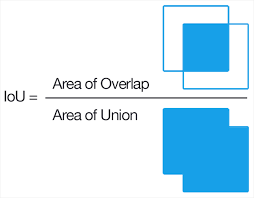

In [14]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [15]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y.float())
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [16]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.42560 iou 0.82086
Epoch 2/100 loss 0.42497 iou 0.80023
Epoch 3/100 loss 0.37621 iou 0.91729
Epoch 4/100 loss 0.35630 iou 0.93285
Epoch 5/100 loss 0.33791 iou 0.93420
Epoch 6/100 loss 0.31905 iou 0.93989
Epoch 7/100 loss 0.29985 iou 0.94829
Epoch 8/100 loss 0.28150 iou 0.95564
Epoch 9/100 loss 0.26446 iou 0.95984
Epoch 10/100 loss 0.24840 iou 0.96427
Epoch 11/100 loss 0.23341 iou 0.96916
Epoch 12/100 loss 0.21959 iou 0.97235
Epoch 13/100 loss 0.20669 iou 0.97396
Epoch 14/100 loss 0.19462 iou 0.97472
Epoch 15/100 loss 0.18326 iou 0.97535
Epoch 16/100 loss 0.17251 iou 0.97692
Epoch 17/100 loss 0.16259 iou 0.97792
Epoch 18/100 loss 0.15336 iou 0.97888
Epoch 19/100 loss 0.14469 iou 0.97969
Epoch 20/100 loss 0.13661 iou 0.98081
Epoch 21/100 loss 0.12915 iou 0.98206
Epoch 22/100 loss 0.12231 iou 0.98211
Epoch 23/100 loss 0.11629 iou 0.98197
Epoch 24/100 loss 0.11069 iou 0.97936
Epoch 25/100 loss 0.10444 iou 0.98378
Epoch 26/100 loss 0.09941 iou 0.98378
Epoch 27/100 loss 0.0

Ahora podemos generar predicciones para obtener máscaras de segmentación

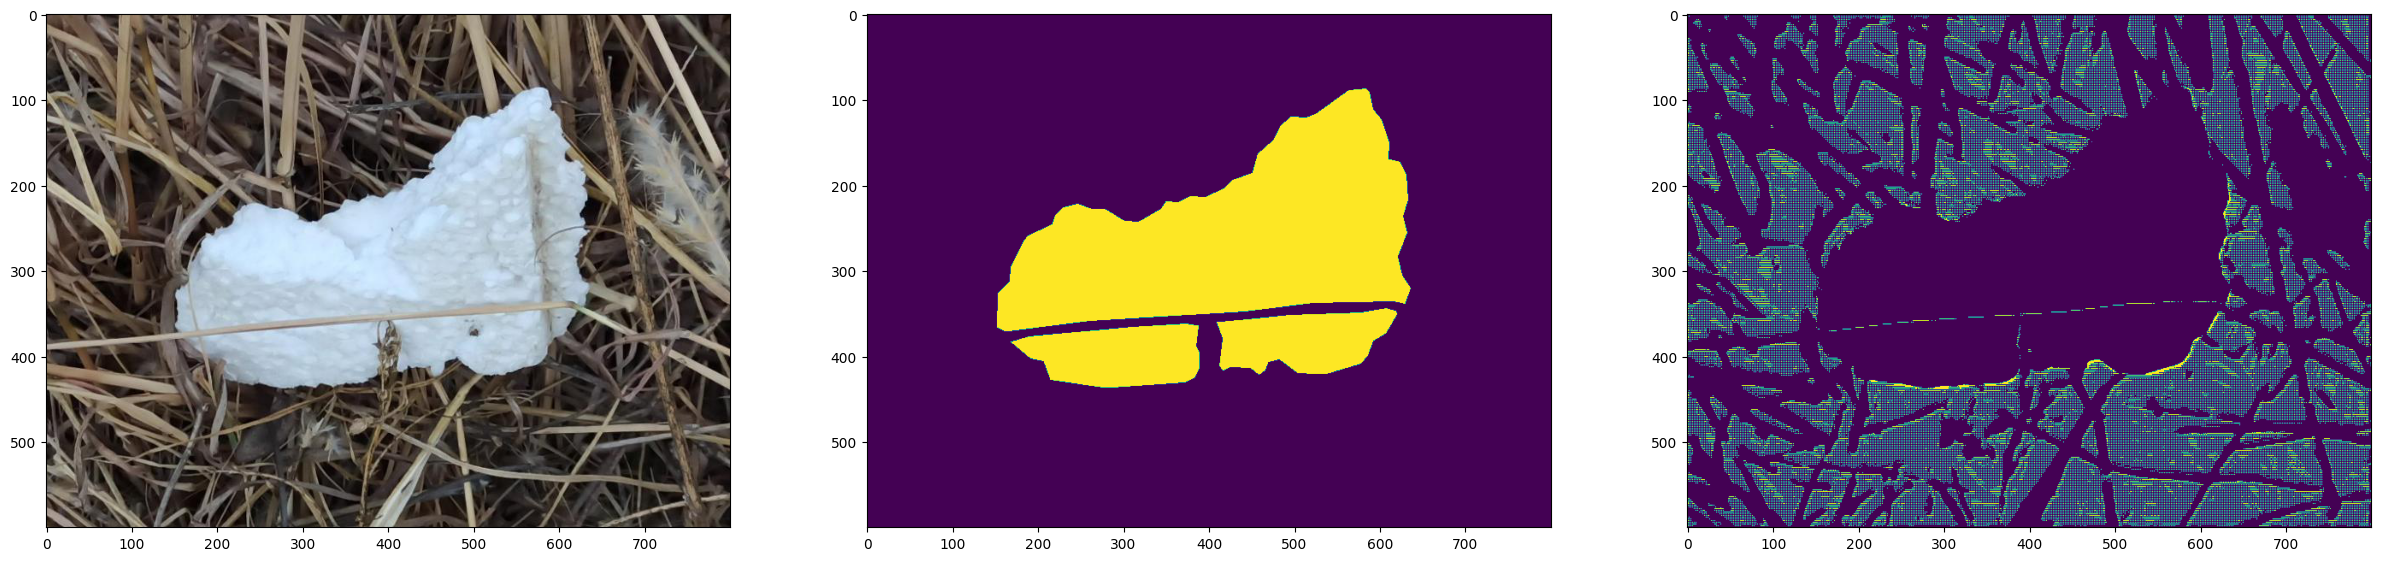

In [17]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Entrenando con todo el dataset

Una vez hemos validado que nuestra red es capaz de hacer el fit de una imágen, podemos entrenar la red con todo el dataset.

In [28]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    img = torch.tensor(img).unsqueeze(0) 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [29]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(900, 100)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.70675 test_iou 0.10390: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Epoch 1/30 loss 0.62166 iou 0.20774 test_loss 0.70675 test_iou 0.10390


test_loss 0.49628 test_iou 0.27513: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Epoch 2/30 loss 0.47497 iou 0.33620 test_loss 0.49628 test_iou 0.27513


test_loss 0.35370 test_iou 0.26779: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



Epoch 3/30 loss 0.37185 iou 0.33700 test_loss 0.35370 test_iou 0.26779


test_loss 0.27092 test_iou 0.30179: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]



Epoch 4/30 loss 0.29318 iou 0.30329 test_loss 0.27092 test_iou 0.30179


test_loss 0.24033 test_iou 0.30954: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]



Epoch 5/30 loss 0.23933 iou 0.31230 test_loss 0.24033 test_iou 0.30954


test_loss 0.20188 test_iou 0.33137: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]



Epoch 6/30 loss 0.20532 iou 0.33839 test_loss 0.20188 test_iou 0.33137


test_loss 0.17010 test_iou 0.46408: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]



Epoch 7/30 loss 0.17479 iou 0.41734 test_loss 0.17010 test_iou 0.46408


test_loss 0.14413 test_iou 0.64197: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]



Epoch 8/30 loss 0.15195 iou 0.58596 test_loss 0.14413 test_iou 0.64197


test_loss 0.13750 test_iou 0.60851: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]



Epoch 9/30 loss 0.13425 iou 0.66052 test_loss 0.13750 test_iou 0.60851


test_loss 0.12068 test_iou 0.69116: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]



Epoch 10/30 loss 0.12182 iou 0.68370 test_loss 0.12068 test_iou 0.69116


test_loss 0.11757 test_iou 0.65860: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]



Epoch 11/30 loss 0.11156 iou 0.70245 test_loss 0.11757 test_iou 0.65860


test_loss 0.10580 test_iou 0.70951: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]



Epoch 12/30 loss 0.10317 iou 0.71382 test_loss 0.10580 test_iou 0.70951


test_loss 0.10201 test_iou 0.72616: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]



Epoch 13/30 loss 0.09662 iou 0.72313 test_loss 0.10201 test_iou 0.72616


test_loss 0.10323 test_iou 0.68121: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]



Epoch 14/30 loss 0.09251 iou 0.72458 test_loss 0.10323 test_iou 0.68121


test_loss 0.09270 test_iou 0.70320: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]



Epoch 15/30 loss 0.08896 iou 0.72433 test_loss 0.09270 test_iou 0.70320


test_loss 0.08614 test_iou 0.73412: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]



Epoch 16/30 loss 0.08394 iou 0.73592 test_loss 0.08614 test_iou 0.73412


test_loss 0.08762 test_iou 0.71974: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]



Epoch 17/30 loss 0.07952 iou 0.74346 test_loss 0.08762 test_iou 0.71974


test_loss 0.08309 test_iou 0.72011: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]



Epoch 18/30 loss 0.07752 iou 0.74435 test_loss 0.08309 test_iou 0.72011


test_loss 0.08021 test_iou 0.72958: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]



Epoch 19/30 loss 0.07562 iou 0.74499 test_loss 0.08021 test_iou 0.72958


test_loss 0.07580 test_iou 0.74606: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]



Epoch 20/30 loss 0.07132 iou 0.75808 test_loss 0.07580 test_iou 0.74606


test_loss 0.07473 test_iou 0.74303: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]



Epoch 21/30 loss 0.06887 iou 0.76206 test_loss 0.07473 test_iou 0.74303


test_loss 0.07278 test_iou 0.75185: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]



Epoch 22/30 loss 0.06801 iou 0.76130 test_loss 0.07278 test_iou 0.75185


test_loss 0.07300 test_iou 0.74772: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]



Epoch 23/30 loss 0.06594 iou 0.76482 test_loss 0.07300 test_iou 0.74772


test_loss 0.07292 test_iou 0.73862: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]



Epoch 24/30 loss 0.06428 iou 0.76943 test_loss 0.07292 test_iou 0.73862


test_loss 0.07257 test_iou 0.74149: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 25/30 loss 0.06238 iou 0.77411 test_loss 0.07257 test_iou 0.74149


test_loss 0.06950 test_iou 0.74740: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Epoch 26/30 loss 0.06233 iou 0.77140 test_loss 0.06950 test_iou 0.74740


test_loss 0.06823 test_iou 0.75641: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]



Epoch 27/30 loss 0.06025 iou 0.77599 test_loss 0.06823 test_iou 0.75641


test_loss 0.07899 test_iou 0.70747: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]



Epoch 28/30 loss 0.05777 iou 0.78404 test_loss 0.07899 test_iou 0.70747


test_loss 0.06699 test_iou 0.75853: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]



Epoch 29/30 loss 0.05623 iou 0.78902 test_loss 0.06699 test_iou 0.75853


test_loss 0.06538 test_iou 0.76138: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Epoch 30/30 loss 0.05581 iou 0.78918 test_loss 0.06538 test_iou 0.76138


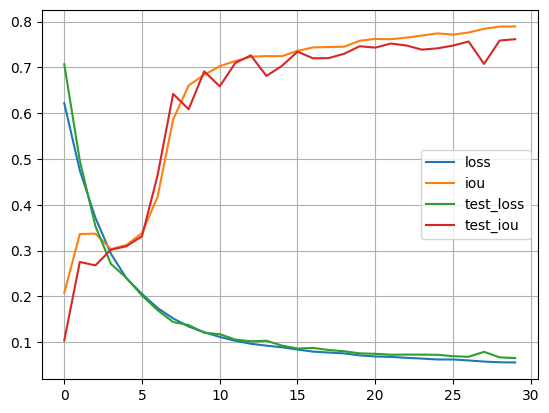

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Transfer Learning

Podemos mejorar nuestros resultados si en vez de entrenar nuestra `UNet` desde cero utilizamos una red ya entrenada gracias al `transfer learning`. Para ello usaremos `ResNet` como `backbone` en el `encoder` de la siguiente manera.

In [ ]:
import torchvision

In [ ]:
encoder = torchvision.models.resnet18(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [ ]:
model = UNetResnet()
output = model(torch.randn((10,1,394,394)))
output.shape

<ipython-input-27-79df0860ce6f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


torch.Size([10, 3, 394, 394])

In [ ]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

  0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-27-79df0860ce6f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.63654 test_iou 0.01199: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]



Epoch 1/30 loss 0.57389 iou 0.34417 test_loss 0.63654 test_iou 0.01199


test_loss 0.45212 test_iou 0.62729: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]



Epoch 2/30 loss 0.43842 iou 0.63087 test_loss 0.45212 test_iou 0.62729


test_loss 0.37330 test_iou 0.67161: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]



Epoch 3/30 loss 0.38668 iou 0.69335 test_loss 0.37330 test_iou 0.67161


test_loss 0.33334 test_iou 0.72890: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 4/30 loss 0.34907 iou 0.71997 test_loss 0.33334 test_iou 0.72890


test_loss 0.30195 test_iou 0.74146: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]



Epoch 5/30 loss 0.31674 iou 0.73640 test_loss 0.30195 test_iou 0.74146


test_loss 0.27605 test_iou 0.75593: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 6/30 loss 0.28629 iou 0.75853 test_loss 0.27605 test_iou 0.75593


test_loss 0.25833 test_iou 0.73486: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 7/30 loss 0.25816 iou 0.77607 test_loss 0.25833 test_iou 0.73486


test_loss 0.23619 test_iou 0.75010: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 8/30 loss 0.23585 iou 0.77619 test_loss 0.23619 test_iou 0.75010


test_loss 0.21064 test_iou 0.78156: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]



Epoch 9/30 loss 0.21211 iou 0.79936 test_loss 0.21064 test_iou 0.78156


test_loss 0.19236 test_iou 0.77758: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]



Epoch 10/30 loss 0.19362 iou 0.80321 test_loss 0.19236 test_iou 0.77758


test_loss 0.17770 test_iou 0.78206: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]



Epoch 11/30 loss 0.17407 iou 0.82133 test_loss 0.17770 test_iou 0.78206


test_loss 0.16502 test_iou 0.77847: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]



Epoch 12/30 loss 0.15691 iou 0.83578 test_loss 0.16502 test_iou 0.77847


test_loss 0.14973 test_iou 0.79698: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 13/30 loss 0.14371 iou 0.83909 test_loss 0.14973 test_iou 0.79698


test_loss 0.14063 test_iou 0.78844: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 14/30 loss 0.13084 iou 0.84904 test_loss 0.14063 test_iou 0.78844


test_loss 0.12790 test_iou 0.80446: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 15/30 loss 0.12073 iou 0.85173 test_loss 0.12790 test_iou 0.80446


test_loss 0.12566 test_iou 0.79132: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 16/30 loss 0.11031 iou 0.86264 test_loss 0.12566 test_iou 0.79132


test_loss 0.11312 test_iou 0.80548: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]



Epoch 17/30 loss 0.10235 iou 0.86476 test_loss 0.11312 test_iou 0.80548


test_loss 0.10880 test_iou 0.80553: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 18/30 loss 0.09472 iou 0.86997 test_loss 0.10880 test_iou 0.80553


test_loss 0.10368 test_iou 0.80275: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]



Epoch 19/30 loss 0.08750 iou 0.87722 test_loss 0.10368 test_iou 0.80275


test_loss 0.10012 test_iou 0.80503: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]



Epoch 20/30 loss 0.08161 iou 0.87957 test_loss 0.10012 test_iou 0.80503


test_loss 0.09434 test_iou 0.80517: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]



Epoch 21/30 loss 0.07667 iou 0.88090 test_loss 0.09434 test_iou 0.80517


test_loss 0.09558 test_iou 0.77948: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 22/30 loss 0.07387 iou 0.87282 test_loss 0.09558 test_iou 0.77948


test_loss 0.08823 test_iou 0.80608: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]



Epoch 23/30 loss 0.06926 iou 0.88020 test_loss 0.08823 test_iou 0.80608


test_loss 0.08364 test_iou 0.81239: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]



Epoch 24/30 loss 0.06458 iou 0.88585 test_loss 0.08364 test_iou 0.81239


test_loss 0.08166 test_iou 0.81439: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 25/30 loss 0.06030 iou 0.89275 test_loss 0.08166 test_iou 0.81439


test_loss 0.08206 test_iou 0.80445: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 26/30 loss 0.05798 iou 0.88895 test_loss 0.08206 test_iou 0.80445


test_loss 0.08338 test_iou 0.79087: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]



Epoch 27/30 loss 0.05357 iou 0.90091 test_loss 0.08338 test_iou 0.79087


test_loss 0.07878 test_iou 0.80374: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]



Epoch 28/30 loss 0.05111 iou 0.90238 test_loss 0.07878 test_iou 0.80374


test_loss 0.07632 test_iou 0.80805: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]



Epoch 29/30 loss 0.04925 iou 0.89911 test_loss 0.07632 test_iou 0.80805


test_loss 0.07357 test_iou 0.81313: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Epoch 30/30 loss 0.04625 iou 0.90645 test_loss 0.07357 test_iou 0.81313


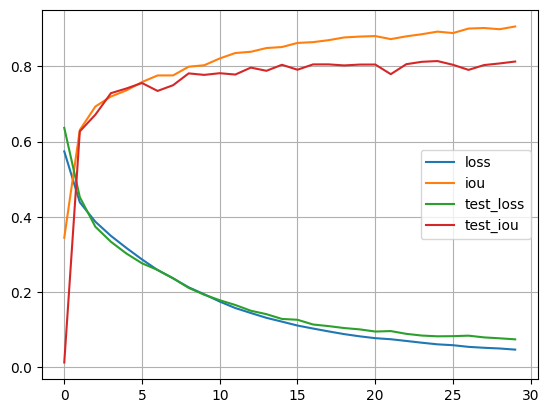

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

En este caso observamos como la red converge más rápido, sin embargo no obtenemos una gran mejora de prestaciones ya que nuestro dataset es muy pequeño y la naturaleza de las imágenes es muy distinta a las utilizadas para entrenar `ResNet`. Podemos generar máscaras para imágenes del dataset de test de la siguiente manera.

<ipython-input-27-79df0860ce6f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


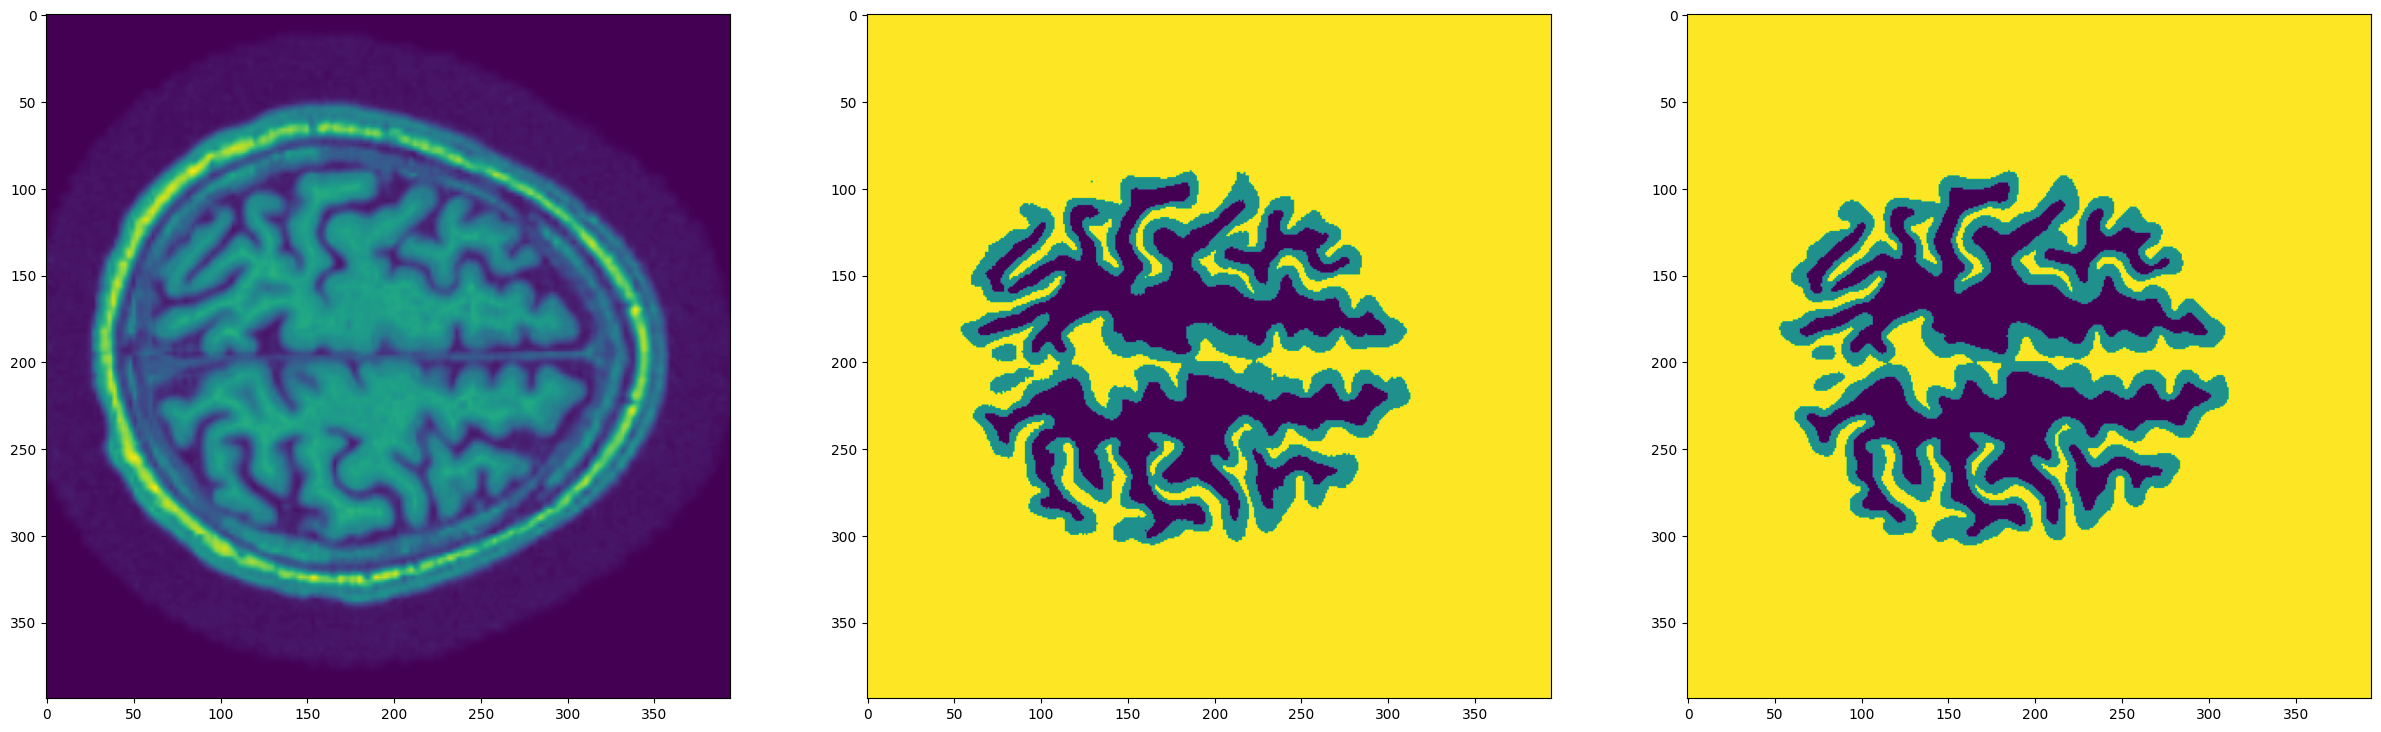

In [ ]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Resumen

En este post hemos visto como podemos implementar y entrenar una red convolucional para llevar a cabo la tarea de segmentación semántica. Esta tarea consiste en clasificar todos y cada uno de los píxeles en una imagen. De esta manera podemos producir máscaras de segmentación que nos permiten localizar los diferentes objetos presentes en una imagen de forma mucho más precisa que la que podemos conseguir con la detección de objetos. Este tipo de tarea puede utilizarse en aplicaciones como la conducción autónoma o sistemas de diagnóstico médico, como hemos visto en el ejemplo de este post.